**If you are a Colab user**

If you use Google Colab, you can uncomment the following cell to mount your Google Drive to Colab. After that, Clab can read/write files and data in your Google Drive

please change the current directory to be the folder that you save your Notebook and data folder. For example, I save my Colab files and data in the following location

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

#%cd /content/drive/MyDrive/Colab\ Notebooks

## MLP Implementation

This is an implementation of Multi-layer Perceptron (MLP) using the dataset FashionMNIST in torch. 

Becausethis class did not teach PyTorch, a deep learning framework, detailed notes are provided for this first neural network models we develop.



Training samples: 48000 | Validation samples: 12000 | Test samples: 10000
MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=10, bias=True)
)
Epoch [ 1/60] TrainLoss 0.8833 TrainAcc 70.17% | ValLoss 0.5956  ValAcc 78.77%
Epoch [ 2/60] TrainLoss 0.5879 TrainAcc 79.43% | ValLoss 0.5329  ValAcc 80.78%
Epoch [ 3/60] TrainLoss 0.5299 TrainAcc 81.23% | ValLoss 0.4887  ValAcc 82.46%
Epoch [ 4/60] TrainLoss 0.4944 TrainAcc 82.50% | ValLoss 0.4575  ValAcc 83.63%
Epoch [ 5/60] TrainLoss 0.4716 TrainAcc 83.26% | ValLoss 0.4439  ValAcc 84.28%
Epoch [ 6/60] TrainLoss 0.4531 TrainAcc 83.97% | ValLoss 0.4336  ValAcc 84.23%
Epoch [ 7/60] TrainLoss 0.4363 TrainAcc 84.45% | ValLoss 0.4182  ValAcc 84.99%
Epoch [ 8/60] TrainLoss 0.4244 TrainAcc 84.90% | ValLoss 0.4125  ValAcc 85.24%
Epoch [ 9/60] TrainLoss 0.4171 TrainAcc 85.24% | ValLoss 0

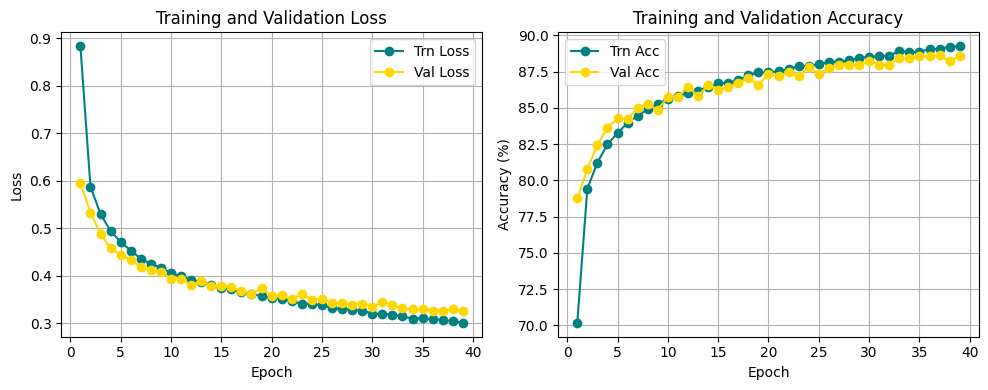

In [2]:
# === import libraries and modules that we need === #
import torch # PyTorch library
import torch.nn as nn # the neural network submodule of PyTorch
import torch.optim as optim # PyTorch's optimization package that provides algorithms to update model parameters based on gradients
from torchvision import datasets, transforms  # two key components from torchvision, a library built on top of PyTorch for computer vision tasks.
from torch.utils.data import DataLoader, random_split # tools to handle datasets
import matplotlib.pyplot as plt
import os

# === Hyperparameters === #
batch_size = 256          # batch size
lr = 0.05                 # learning rate
max_epochs = 60           # maximum number of epochs
max_wait = 3              # maximum number of epochs to wait before early termination
eps_early = 1e-3 # threshold in terms of the change in loss for triggering early termination
dropout_prob = 0.5        # probability of dropping a neuron
best_path = "best_model_mlp_demo.pth"  # directory for saving the best model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use GPU if available. Otherwise, use CPU 

# === Data Preparation === #
# define data pre-processing
transform = transforms.Compose([
    transforms.ToTensor(), # convert data to pytorch tensors and then normalize the data to be within the range [0, 1]
    transforms.Normalize((0.5,), (0.5,)) # further rescale the data to be within the range of [-1,1] using mean=0.5 and std=0.5
])

# download data and apply the defined data pre-processing
full_train = datasets.FashionMNIST(root="./data", train=True, transform=transform, download=True) # load the training dataset and apply the transform we defined
test_set = datasets.FashionMNIST(root="./data", train=False, transform=transform, download=True) # load the test dataset and apply the transform we defined

# split the total training dataset into train and validation in 4:1 ratio
full_train_size = len(full_train)
train_ratio = 0.8
val_ratio = 0.2
train_size = int(full_train_size * train_ratio)
val_size = full_train_size - train_size
train_set, val_set = random_split(full_train, [train_size, val_size]) 

print(f"Training samples: {train_size} | Validation samples: {val_size} | Test samples: {len(test_set)}")


# loading mini-batches of data using DataLoader
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True) # Shuffling ensures that each mini-batch is a random mix of samples the training data. Thereby, the model sees the data in a different order each epoch, improving generalization.
val_loader   = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_set, batch_size=batch_size, shuffle=False)

# === Define the MLP Model === #
class MLP(nn.Module): # define the desired MLP model as a new class named MLP
    # define the model architecture by stacking layers sequentially
    def __init__(self):
        super().__init__() # initializes the parent nn.Module class 
        self.flatten = nn.Flatten() # convert each 28x28 image into a 1d vector of size 784
        self.fc1 = nn.Linear(28*28, 256) # a fully connected hidden layer with 256 neurons [input size=28*28 and output size=256] 
        self.relu = nn.ReLU() # activation function is ReLU
        self.dropout = nn.Dropout(dropout_prob)   # dropout layer at prespecified dropput probability. This is executed only in training
        self.fc2 = nn.Linear(256, 10) # a fully connected layer mapping 256 hidden neurons to 10 output neurons

    # define the forward propagation process. That is how the data flows through the MLP
    def forward(self, x):
        x = self.flatten(x) # this is the input layer. The input image is flattened into a vector
        x = self.fc1(x) # this is the intermediate variable z = W^(1)x
        x = self.relu(x) # this is the activation function h = relu(z)
        x = self.dropout(x) ## this is the dropout regularization     
        x = self.fc2(x) # this is the output layer y=W^(2)h
        return x

# Creates an instance of the MLP model and move it to GPU or CPU, depending on the device available
mlp_model = MLP().to(device)
print(mlp_model)

# === Define Loss Function and Optimizer ===#

# define the loss as the cross-entropy loss function for this multiclass classification problem
loss_metric = nn.CrossEntropyLoss() 

# define the optimizer. Here we choose the stochastic gradient descent (SGD) algorithm with a learning rate, lr. 
# Details about the SGD algorithm is available at https://docs.pytorch.org/docs/stable/generated/torch.optim.SGD.html
# You can configure other parameters of this algorithm
optimizer = optim.SGD(mlp_model.parameters(), lr=lr) 

# === Model Training ===#
train_loss, val_loss = [], []
train_acc, val_acc = [], []

best_val_loss = float("inf")
wait = 0

for epoch in range(1, max_epochs + 1):
    
    # training
    mlp_model.train() # put the model in the training mode    
    train_running_loss = 0.0 # save the sum of the batch losses to compute average loss 
    train_correct = 0 # the number of correctly classified data points
    train_total = 0 # the total number of data points seen so far
    # Within each epoch, optimize the model using mini-batches sequentially, until all mini-batches are used
    for imgs, labels in train_loader: #imgs are input images (x), labels are corresponding ground truth (y), 
        imgs, labels = imgs.to(device), labels.to(device) # move data to the same device as where the model is

        optimizer.zero_grad() # reset the gradients as zeros by clearing old gradients from the previous step
        outputs = mlp_model(imgs) # feeds input to the model to get the output. This is the forward propagation process.
        loss = loss_metric(outputs, labels) # outouts are predicted labels, and labels are ground truth. this calculates the loss
        loss.backward() # backwardpropagation
        optimizer.step() # updates the model parameters using the computed gradients

        train_running_loss += loss.item()*imgs.size(0) # loss.item() extracts the average loss for each batch from the PyTorch tensor. running_loss accumualtes the total loss of each batch over batches
        preds = outputs.argmax(dim=1) # argmax(dim=1) finds the index of the highest logit for each datapoint in the batch. This convert the model’s outputs (logits) to predicted class
        train_correct += (preds == labels).sum().item() #count the number of correctly predicted data points and accumulate the count over batches
        train_total += labels.size(0) # count the number of data points in each batch and accumulate the count over batches

    
    train_epoch_loss = train_running_loss / train_total # the average training loss for the epoch is found by dividing the total losses by total number of training data points
    train_epoch_acc = 100*train_correct / train_total # accuracy = # correct predictions/# data points

    # save the training loss and training accuracy so that we can visualize the training history
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)


    # validation 
    mlp_model.eval()    # validation mode
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = mlp_model(imgs)
            loss = loss_metric(outputs, labels)
            val_running_loss += loss.item()*imgs.size(0)
            preds = outputs.argmax(dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_running_loss / val_total
    val_epoch_acc = 100.0 * val_correct / val_total

    # save the validation loss and validation accuracy so that we can visualize the training history
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)

    
    print(f"Epoch [{epoch:2d}/{max_epochs}] "
          f"TrainLoss {train_epoch_loss:.4f} TrainAcc {train_epoch_acc:5.2f}% | "
          f"ValLoss {val_epoch_loss:.4f}  ValAcc {val_epoch_acc:5.2f}%")

    # Early Stopping
    if val_epoch_loss < best_val_loss - eps_early:
        best_val_loss = val_epoch_loss
        wait = 0
        torch.save(mlp_model.state_dict(), best_path)
    else:
        wait += 1
        if wait >= max_wait:
            print(f"\nEarly stopping triggered at epoch {epoch+1} because no improvement in validation loss.")
            break

# === Load best model and evaluate on test dataset === #
print('\nLoading the best model and evaluating on the test set...')
if os.path.exists(best_path):
    mlp_model.load_state_dict(torch.load(best_path)) #torch.load(best_path) loads the saved state dictionary, which consists of all the trained parameters (weights and biases) of the model. load_state_dict() loads the saved model parameters into the model 


# evaluate on the test dataset
mlp_model.eval() # validation mode
test_running_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs =mlp_model(imgs)
        test_running_loss += loss_metric(outputs, labels).item()
        preds = outputs.argmax(dim=1)
        test_correct += (preds == labels).sum().item()
        test_total += labels.size(0)

test_loss = test_running_loss / len(test_loader)
test_acc = 100.0 * test_correct / test_total
print(f"TestLoss {test_loss:.4f}  TestAcc {test_acc:.2f}%")

# === Plot Training History === #
epochs = range(1, len(train_loss) + 1)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Left subplot: Loss
axes[0].plot(epochs, train_loss, marker='o', color='teal', label="Trn Loss")
axes[0].plot(epochs, val_loss, marker='o', color='gold', label="Val Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training and Validation Loss")
axes[0].legend()
axes[0].grid(True)

# Right subplot: Accuracy 
axes[1].plot(epochs, train_acc, marker='o', color='teal', label="Trn Acc")
axes[1].plot(epochs, val_acc, marker='o', color='gold', label="Val Acc")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy (%)")
axes[1].set_title("Training and Validation Accuracy")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show();


## Damage Level Classification 

This example is an application of MLP to structural damage assessment, contributed by Mohammad Monjurul Karim (SBU CIV Ph.D.'23). 

In this example, we develop a classification model for classifying inspection images: crack (Positive) vs. no crack (Negative) on concrete surface.

The dataset NNdata can be downloaded from the link below

https://drive.google.com/file/d/1eGFtTcg0nsbJCGYOpRoTA7ifOBabmknN/view?usp=sharing

Using device: cpu
Training samples: 768 | Validation samples: 192 | Test samples: 240
SimpleFCNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2352, out_features=512, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=512, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)
Epoch [ 1/100] Trn Loss: 0.7011 Trn Acc: 49.48% | Val Loss: 0.6957 Val Acc: 48.96%
Epoch [ 2/100] Trn Loss: 0.6857 Trn Acc: 55.73% | Val Loss: 0.6857 Val Acc: 51.04%
Epoch [ 3/100] Trn Loss: 0.6845 Trn Acc: 57.68% | Val Loss: 0.6743 Val Acc: 76.04%
Epoch [ 4/100] Trn Loss: 0.6730 Trn Acc: 66.80% | Val Loss: 0.6683 Val Acc: 52.08%
Epoch [ 5/100] Trn Loss: 0.6770 Trn Acc: 57.94% | Val Loss: 0.6646 Val Acc: 52.60%
Epoch [ 6/100] Trn Loss: 0.6677 Trn Acc: 55.08% | Val Loss: 0.6700 Val Acc: 48.44%
Epoch [ 7/100] Trn Loss: 0.6616 Trn Acc: 58.20% | Val Loss: 0.6574 Val Acc: 54.17%
Epoch [ 8/100] Trn Loss: 0.6649 Trn Acc: 56.64% | Val Loss: 0.6611 Val Acc: 50.52%
Epoch [ 9/100] Trn Loss: 0.

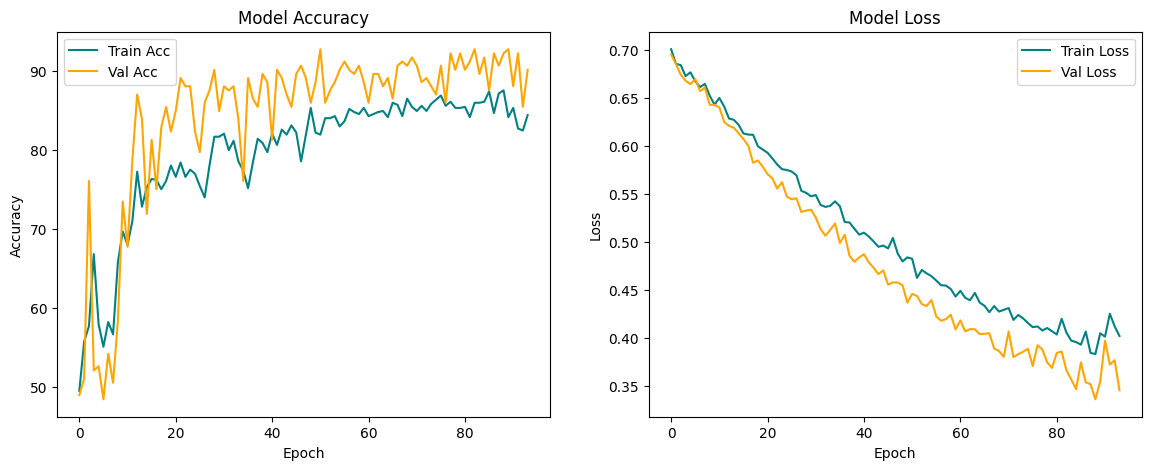

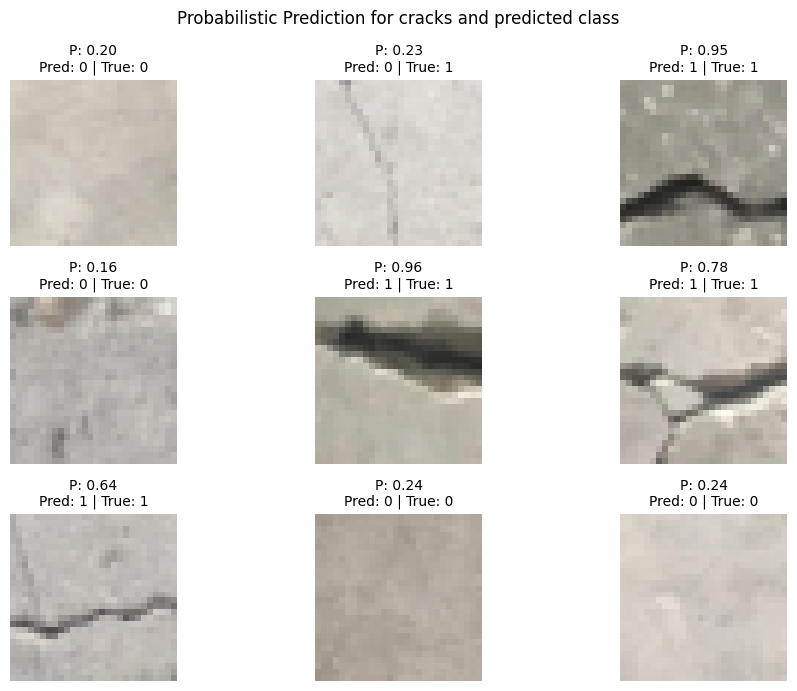

In [4]:
# === import libraries and modules that we need ===%
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms 
import matplotlib.pyplot as plt
import time
import random
import os

# === Hyperparameters === #
batch_size = 128
max_epochs = 100
max_wait = 5
eps_early = 1e-8
lr = 0.0001
checkpoint_filepath = 'Data/NNdata/model_best_weights_CrackRec.pth' # change the path to where you would like to save your model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # cpu should be fine for this example
print("Using device:", device)

# === Dataset setup === #
# NNdata is the folder we save  the data. 
# - NNdata
#  |-- train
#     |--Positive
#     |--Negative
#  |-- test
#     |--Positive
#     |--Negative

train_data_dir = 'Data/NNdata/train' 
test_data_dir = 'Data/NNdata/test'

img_width, img_height = 28, 28

# === Data preprocessing === #

# pre-processing of the training data
train_transform = transforms.Compose([
    transforms.Resize((img_width, img_height)), # make sure data are resized to the same size as defined
    transforms.RandomHorizontalFlip(),  # data augmentation - hotizontal flip
    transforms.RandomRotation(10),  # data augmentation - random rotation for -10 to 10 deg
    transforms.RandomAffine(degrees=0, shear=10),   # data augmentation - shear for -10 to 10 deg
    transforms.ToTensor() # convert data to the tensor format that PyTorch uses
])

# pre-processing of the test data
test_transform = transforms.Compose([
    transforms.Resize((img_width, img_height)),
    transforms.ToTensor()
])

# Load full training dataset and test dataset
full_train = datasets.ImageFolder(root=train_data_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_data_dir, transform=test_transform)

# Split the full training dataset into train (80%) and validation (20%) 
train_size = int(0.8 * len(full_train))
val_size = len(full_train) - train_size
train_dataset, val_dataset = random_split(full_train, [train_size, val_size])

print(f"Training samples: {len(train_dataset)} | Validation samples: {len(val_dataset)} | Test samples: {len(test_dataset)}")

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ==== Define the Network === #
class SimpleFCNN(nn.Module):
    # define model architecture
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(img_width * img_height * 3, 512) # The first fully connected layer with 512 neurons, this is intermediate variable z_1
        self.relu = nn.ReLU() # apply the ReLU activation function to the first connected layer to become the first hidden layer h_1
        self.fc2 = nn.Linear(512, 1) # The second fully connnected layer with one output, z_2
        self.sigmoid = nn.Sigmoid() # apply the Sigmoid function to map z_2 to the prediction of output y, which is within the range of [0, 1]
        
    # forward propagation
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# pass the model to the device
nn_model = SimpleFCNN().to(device)
print(nn_model)

# ==== Define Loss function and Optimizer ===#
loss_metric = nn.BCELoss() # binary cross-entropy loss for this binary classification problem
optimizer = optim.Adam(nn_model.parameters(), lr=lr)

# === Model Training === #

# initialize variables for tracking the model performance and training progress
best_val_loss = float('inf')
train_loss, val_loss = [], []
train_acc, val_acc = [], []
wait = 0

start_time = time.time()

for epoch in range(max_epochs):
    # Training
    nn_model.train() 
    train_running_loss = 0.0
    train_correct = 0
    train_total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device) # labels are often integer numbers. We convert it to float data type often required by loss function. unsqueeze(1) add a dimention to provide matched shape 
        optimizer.zero_grad()
        outputs = nn_model(images)
        loss = loss_metric(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item() * images.size(0)
        predicted = (outputs > 0.5).float()
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)

    
    train_epoch_loss = train_running_loss / train_total
    train_epoch_acc = 100*train_correct / train_total
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)

    # Validation
    nn_model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
            outputs = nn_model(images)
            loss = loss_metric(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            predicted = (outputs > 0.5).float()
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_running_loss / val_total
    val_epoch_acc = 100*val_correct / val_total
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)

    print(f"Epoch [{epoch+1:2d}/{max_epochs}] "
          f"Trn Loss: {train_epoch_loss:.4f} Trn Acc: {train_epoch_acc:.2f}% | "
          f"Val Loss: {val_epoch_loss:.4f} Val Acc: {val_epoch_acc:.2f}%")


    # Early Stopping
    if val_epoch_loss < best_val_loss - eps_early:
        best_val_loss = val_epoch_loss
        wait = 0
        torch.save(nn_model.state_dict(), checkpoint_filepath)
    else:
        wait += 1
        if wait >= max_wait:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break
   
end_time = time.time()
print('-------------------------------')
print(f"Training time: {end_time - start_time:.2f} seconds")

# === Evaluate Best Model on Test Dataset ===
print('\nLoading the best model and evaluating on the test set...')
nn_model.load_state_dict(torch.load(checkpoint_filepath))
nn_model.eval()

test_running_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.float().unsqueeze(1).to(device)
        outputs = nn_model(images)
        loss = loss_metric(outputs, labels)
        test_running_loss += loss.item() * images.size(0)
        predicted = (outputs > 0.5).float()
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

test_loss = test_running_loss / test_total
test_acc = 100* test_correct / test_total

print(f"\nBest Model Performance on Test Set:")
print(f"Loss: {test_loss:.4f} | Accuracy: {test_acc:.2f}%")

# ==== Plot Training History ===
def plot_training(train_acc, val_acc, train_loss, val_loss):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    axs[0].plot(train_acc, 'teal', label='Train Acc')
    axs[0].plot(val_acc, 'orange', label='Val Acc')
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(loc='upper left')

    axs[1].plot(train_loss, 'teal', label='Train Loss')
    axs[1].plot(val_loss, 'orange', label='Val Loss')
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(loc='upper right')

    plt.show()

plot_training(train_acc, val_acc, train_loss, val_loss)


# === Show predictions of samples in the test dataset === # # Collect predictions for the entire test set 
nn_model.eval() 
all_images = [] 
all_labels = [] 
all_outputs = [] 

with torch.no_grad():
    for images, labels in test_loader: 
        images = images.to(device) 
        outputs = nn_model(images) 
        
        all_images.append(images.cpu()) 
        all_labels.append(labels.cpu()) 
        all_outputs.append(outputs.cpu()) 
        
all_images = torch.cat(all_images) 
all_labels = torch.cat(all_labels) 
all_outputs = torch.cat(all_outputs).numpy() 
        

# Choose 9 random indices 
random_indices = random.sample(range(len(all_images)), 9) 

# Plot the predictions 
fig = plt.figure(figsize=(10,7)) 
fig.suptitle('Probabilistic Prediction for cracks and predicted class') 

for k, i in enumerate(random_indices): 
    ax = fig.add_subplot(3, 3, k+1) 
    img = all_images[i].permute(1,2,0).numpy() # CHW -> HWC 
    
    plt.imshow(img) 
    plt.axis('off') 
    prob = all_outputs[i][0] 
    pred_class = int(prob > 0.5) 
    true_class = int(all_labels[i].item()) 
    plt.title(f'P: {prob:.2f}\nPred: {pred_class} | True: {true_class}', fontsize=10) 

plt.tight_layout() 
plt.show();
